In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from IPython import display
from utils import *
pre_trained_model = tf.keras.models.load_model('saved_model/my_model')

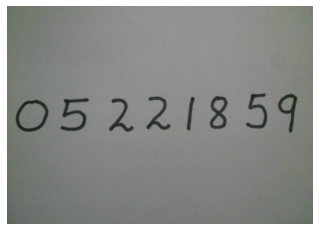

In [3]:
image = cv2.imread('data/image.png')
plt.axis('off')
plt.imshow(image);

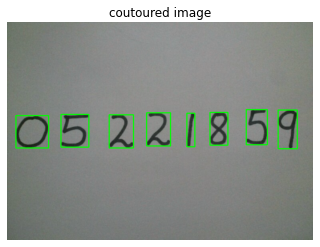

In [4]:
grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(grey.copy(), (5,5), 0)
_, thresh = cv2.threshold(blur.copy(),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_rect = [cv2.boundingRect(c) for c in contours]

img = image.copy()
small_param = 0.001
digits = []

for x,y,w,h in sorted(contours_rect):
    
    # filter out small rect
    if w*h < small_param * img.shape[0] * img.shape[1]:
        continue
    
    cv2.rectangle(img, (x,y), (x+w, y+h), color=(0,255,0), thickness=2)
    
    digit = thresh[y:y+h, x:x+w]
    resized_digit = cv2.resize(digit, (18,18))
    padded_digit = np.pad(resized_digit, 5, "constant", constant_values=0)
    
    digits.append(padded_digit)

digits = np.array(digits)

plt.title('coutoured image')
plt.axis('off')
plt.imshow(img, cmap="gray")
plt.show()

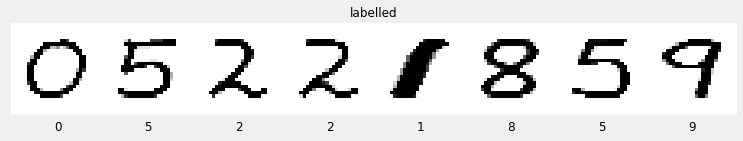

In [6]:
labels = []
del_idx = []
for i, digit in enumerate(digits):
    plt.axis('off')
    plt.imshow(digit, cmap='gray')
    plt.show()
    is_valid_inp = lambda x : x.isdigit() and int(x) >= 0 and int(x) <= 9
    
    # walrus operator returns value
    while not is_valid_inp(x := input()) and x != 'x':
        print("please enter single digit or 'x'")
        continue
    
    if is_valid_inp(x):
        labels.append(int(x))
    elif x == 'x':
        del_idx.append(i)
    
    display.clear_output(wait=True)

digits = np.delete(digits, del_idx, 0)
labels = np.array(labels)
display.clear_output()
display_digits(digits, labels, labels, 'labelled', len(labels))

In [7]:
digits = tf.constant(digits)
digits = digits[..., tf.newaxis]
digits = tf.image.resize(digits, (28,28))
digits = digits.numpy()
digits = digits.reshape(-1,28*28)
digits.shape

(8, 784)

In [8]:
pred = pre_trained_model.predict(digits)
pred = [np.argmax(p) for p in pred]
pred = np.array(pred)
pred

1/1 [==============================] - 1s 600ms/step


array([0, 5, 2, 2, 1, 3, 5, 9], dtype=int64)

In [9]:
res = pred == labels
acc = res[res].sum() / res.shape[0] * 100
acc

87.5

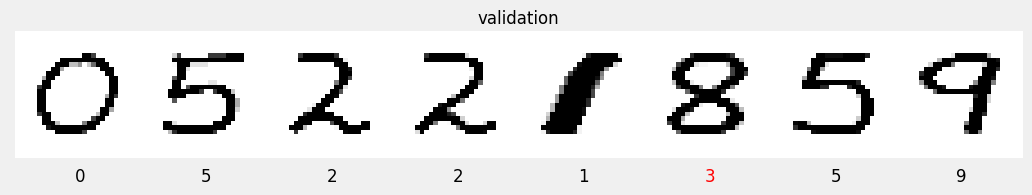

In [10]:
display_digits(digits, pred, labels, 'validation', pred.shape[0])